In [77]:
import os 
from pathlib import Path
from dotenv import load_dotenv
import pickle
import pandas as pd
import torch
from tqdm import tqdm
import seaborn as sns

In [78]:
load_dotenv()

True

In [79]:
base_path = Path.home()/Path(os.environ.get("SAVE_PATH"))

In [80]:
# loading slateq results
ALPHA = 0.25
SEEDS = [5, 7, 46, 53, 77]
SEEDS1=[5, 7, 77, 46, 53]
window = 100

In [81]:
def parse_data(data_dict: dict, alg_nam:str, seed: int)->pd.DataFrame:
    # convert from torch to float
    for k, v in data_dict.items():
        if isinstance(v, torch.Tensor):
            data_dict[k] = v.item()
        elif isinstance(v, list):
            if isinstance(v[0], torch.Tensor):
                data_dict[k] = [x.item() for x in v]
    data_df = pd.DataFrame(data_dict)
    data_df["alg_name"] = alg_nam
    data_df["seed"] = seed
    data_df = data_df.reset_index().rename(columns={"index": "episode"})
    data_df["ep_cum_satisfaction_rm_5"] = data_df["ep_cum_satisfaction"].rolling(window=5).mean()
    data_df["ep_cum_satisfaction_rm_10"] = data_df["ep_cum_satisfaction"].rolling(window=10).mean()
    data_df["ep_cum_satisfaction_rm_20"] = data_df["ep_cum_satisfaction"].rolling(window=20).mean()
    data_df["ep_cum_satisfaction_rm_50"] = data_df["ep_cum_satisfaction"].rolling(window=50).mean()
    data_df["ep_cum_satisfaction_rm_100"] = data_df["ep_cum_satisfaction"].rolling(window=100).mean()
    
    return data_df

In [82]:
# load slateq results
res_df_list = []
for seed in tqdm(SEEDS):
    slateq_dict = pickle.load(open(base_path / Path(f"slateq_boredom_{ALPHA}_300_{seed}")/ "logs_dict.pickle", "rb"))
    res_df = parse_data(slateq_dict, "SlateQ", seed)
    res_df_list.append(res_df)
# concat all results
final_df = pd.concat(res_df_list)

100%|██████████| 5/5 [03:05<00:00, 37.04s/it]


In [83]:
# load wp results
res_df_list = []
for seed in tqdm(SEEDS):
    for knearest in [20]:
        slateq_dict = pickle.load(open(base_path / Path(f"proto_item_300_{knearest}_{ALPHA}_{seed}")/ "logs_dict.pickle", "rb"))
        res_df = parse_data(slateq_dict, f"Proto-Item {knearest}%", seed)
        res_df_list.append(res_df)
# concat all results
wp_df = pd.concat(res_df_list)
final_df = pd.concat([final_df, wp_df])

100%|██████████| 5/5 [03:04<00:00, 36.84s/it]


In [84]:
# load wp results
res_df_list = []
for seed in tqdm(SEEDS1):
    for knearest in [20]:
        slateq_dict = pickle.load(open(base_path / Path(f"proto_slate_300_{knearest}_{ALPHA}_{seed}")/ "logs_dict.pickle", "rb"))
        res_df = parse_data(slateq_dict, f"Proto-Slate {knearest}%", seed)
        res_df_list.append(res_df)
# concat all results
# final_df = pd.concat(res_df_list)
wp_slate_df = pd.concat(res_df_list)
final_df = pd.concat([final_df, wp_slate_df])

100%|██████████| 5/5 [03:00<00:00, 36.14s/it]


In [85]:
# # load wp results
# res_df_list = []
# for seed in tqdm(SEEDS):
#     for knearest in [5, 10, 20]:
#         slateq_dict = pickle.load(open(base_path / Path(f"observed_topic_wa_{knearest}_slateq_{ALPHA}_{seed}")/ "logs_dict.pickle", "rb"))
#         res_df = parse_data(slateq_dict, f"Slate-Wolpertinger {knearest}%", seed)
#         res_df_list.append(res_df)
# # concat all results
# wp_df = pd.concat(res_df_list)
# final_df = pd.concat([final_df, wp_df])

In [86]:
final_df = final_df.reset_index(drop=True)

In [87]:
m = 100
n = 50

# apply rolling mean on ep_cum_satisfaction
final_df["ep_cum_satisfaction_rm"] = final_df.groupby("alg_name")["ep_cum_satisfaction"].transform(lambda x: x.rolling(m, 1).mean())
# apply rolling mean on ep_cum_satisfaction
final_df["ep_avg_satisfaction_rm"] = final_df.groupby("alg_name")["ep_avg_satisfaction"].transform(lambda x: x.rolling(m, 1).mean())
# apply rolling mean on ep_cum_satisfaction
final_df["loss_rm"] = final_df.groupby("alg_name")["loss"].transform(lambda x: x.rolling(m, 1).mean())

# Create a new DataFrame that only contains every n-th row of the original DataFrame
new_df = final_df[final_df['episode'] % n == 0]

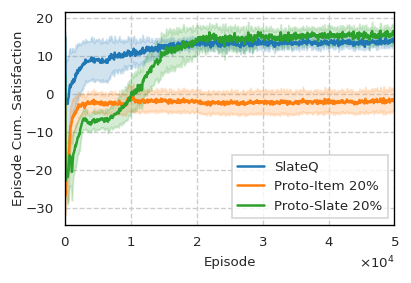

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from setup_plot import setup_plot

setup_plot(font_size=8, w_pts=256, fig_ratio=0.65)

# Set the plot style to "ticks"
sns.set_style("whitegrid", {"grid.linestyle": "--", "axes.edgecolor": "black"})

# Plot the mean of ep_cum_satisfaction across different seeds for each alg_name
ax = sns.lineplot(x="episode", y="ep_cum_satisfaction_rm", hue="alg_name", errorbar="se", data=new_df)

legend = plt.legend(title='', fancybox=False)
# legend.get_frame().set_alpha(None)

# Set the x-axis tick format
fmt = mtick.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((-3,3))
ax.xaxis.set_major_formatter(fmt)

# Add a title and axes labels
plt.xlim(0, 50000)
plt.xlabel("Episode")
plt.ylabel("Episode Cum. Satisfaction", labelpad=0)
plt.savefig("convergence_plot_2000.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [89]:
# # hypothesis satisfied for paired t-test on sq and wp return
# from scipy.stats import ttest_rel
# ttest_rel(sq_return, wp_return)

In [90]:
# compute wilcoxon signed rank test
# from scipy.stats import wilcoxon
# wilcoxon(sq_return, wp_return)